In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

### Gaussian filter 1D

$$
y_i = \sum_{j=-k}^{k} G(j) \cdot x_{i-j}
$$
With : 
$$
G(j) = \frac{1}{Z} \exp\left( -\frac{j^2}{2\sigma^2} \right), \quad Z = \sum_{l=-k}^{k} \exp\left( -\frac{l^2}{2\sigma^2} \right)
$$


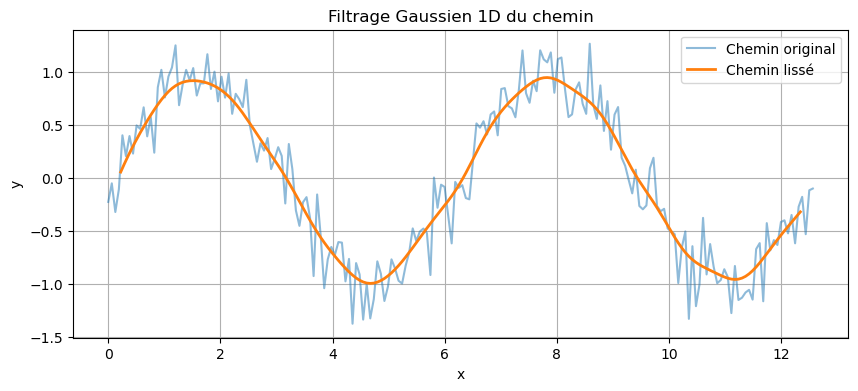

In [3]:

# Crée un chemin avec des oscillations
t = np.linspace(0, 4 * np.pi, 200)
x = t
y = np.sin(t) + 0.2 * np.random.randn(200)  # sinusoïde bruitée
path = np.stack([x, y], axis=1)

# Applique le filtre gaussien
smoothed_x = gaussian_filter1d(path[:, 0], sigma=5)
smoothed_y = gaussian_filter1d(path[:, 1], sigma=5)
smoothed_path = np.stack([smoothed_x, smoothed_y], axis=1)

# Affiche avant/après
plt.figure(figsize=(10, 4))
plt.plot(path[:, 0], path[:, 1], label="Chemin original", alpha=0.5)
plt.plot(smoothed_path[:, 0], smoothed_path[:, 1], label="Chemin lissé", linewidth=2)
plt.legend()
plt.title("Filtrage Gaussien 1D du chemin")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## SDF and velocity

In [4]:
from data_loader import load_sdf_from_csv,vel_read
import matplotlib.colors as mcolors
import numpy as np
from scipy.interpolate import RegularGridInterpolator

Scale : 0.041784223
N : [576, 528, 24]
Min SDF value: -6.4378366
SDF shape after slice: (528, 576)
physical height : 22.062069
physical width : 24.067713
Ratio d'aspect original (points) : 0.9166666666666666
Ratio d'aspect physique (unités) : 0.9166666269302368
Shape new sdf: (528, 576)
Min new sdf: -0.26900000301216137
-0.2675313892182274
-0.13439131432657442


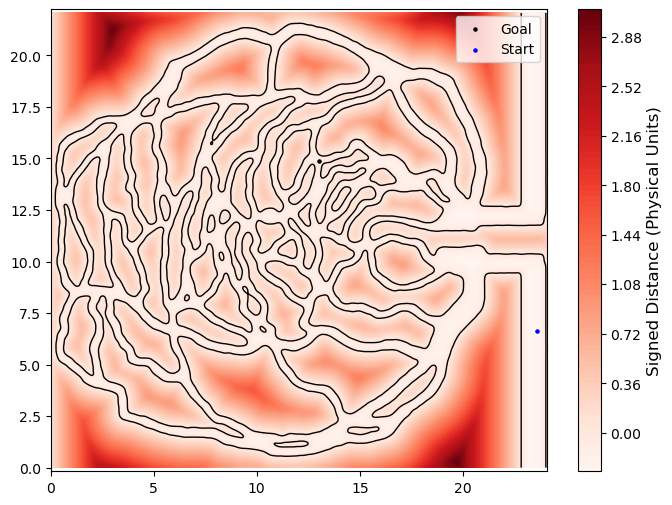

Valeur SDF min physique: -0.26900000301216137, Target: -0.269
dx : 0.04185689240694046 and dy : 0.04186350852251053


In [5]:
L = 0.269
    
x, y, N, _, sdf = load_sdf_from_csv((1, 1))

scale = L / abs(np.min(sdf))
print("Scale :", scale)
print("N :", N)
print("Min SDF value:", np.min(sdf))
print("SDF shape after slice:", sdf.shape)

sdf_interpolator = RegularGridInterpolator(
    (y, x), sdf, bounds_error=False, fill_value=None
)



physical_height = scale * N[1]
physical_width = scale  * N[0]
print('physical height :',physical_height)
print('physical width :',physical_width)

y_phys = np.linspace(0, physical_height, N[1])
x_phys = np.linspace(0, physical_width, N[0])
X_phys, Y_phys = np.meshgrid(x_phys, y_phys)


ratio_original = N[1] / N[0]
ratio_physique =   physical_height / physical_width
print(f"Ratio d'aspect original (points) : {ratio_original}")
print(f"Ratio d'aspect physique (unités) : {ratio_physique}")


Y_norm = Y_phys / physical_height  
X_norm = X_phys / physical_width   


points = np.vstack([Y_norm.ravel(), X_norm.ravel()]).T


sdf_interp = sdf_interpolator(points).reshape(Y_phys.shape)


sdf_phys = sdf_interp * scale

sdf_interp_phys = RegularGridInterpolator(
    (y_phys, x_phys), sdf_phys, bounds_error=False, fill_value=None
)
def sdf_func_phys(point):
    return(sdf_interp_phys(point[::-1]))

print("Shape new sdf:", sdf_phys.shape)
print("Min new sdf:", np.min(sdf_phys))

plt.figure(figsize=(8, 6))
contour = plt.contourf(X_phys, Y_phys, sdf_phys, levels=100, cmap="Reds")
cbar = plt.colorbar(contour)
cbar.set_label("Signed Distance (Physical Units)", fontsize=12)
plt.contour(X_phys, Y_phys, sdf_phys, levels=[0], colors="black", linewidths=1)

start_point = (physical_width * 0.98, physical_height * 0.3)
goal_point = (physical_width * 0.54, physical_height * 0.675)

print(sdf_func_phys(start_point))
print(sdf_func_phys(goal_point))


plt.scatter(goal_point[0], goal_point[1], label="Goal", color="black", s=5)
plt.scatter(start_point[0], start_point[1], label="Start", color="blue", s=5)
plt.axis("equal")  
plt.legend()
plt.show()

print(f"Valeur SDF min physique: {np.min(sdf_phys)}, Target: {-L}")
print(f"dx : {x_phys[1]-x_phys[0]} and dy : {y_phys[1]-y_phys[0]}")



norm V_max on the grid:  4.3930802838480965
norm V_max :  0.18356144698003088


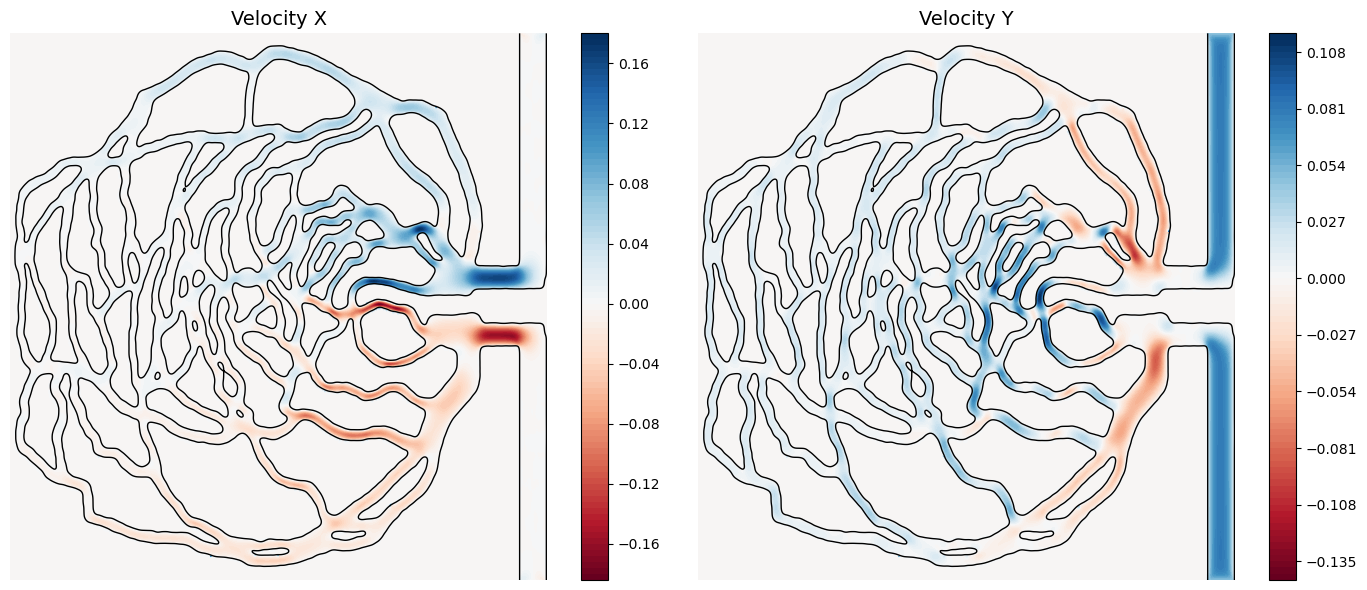

In [6]:
path_vel = "/home/lchoquet/project/microswimmer_internship/data/vel.sdf"
N, h, vel = vel_read(path_vel)
v = vel[N[2] // 2, :, :, 0:2]
vx, vy = v[:, :, 0], v[:, :, 1]
velocity_interpolator_x = RegularGridInterpolator(
    (y, x), vx, bounds_error=False, fill_value=None
)
velocity_interpolator_y = RegularGridInterpolator(
    (y, x), vy, bounds_error=False, fill_value=None
)

vx_interp =  velocity_interpolator_x(points).reshape(Y_phys.shape)
vy_interp =  velocity_interpolator_y(points).reshape(Y_phys.shape)
v_magnitude_or = np.sqrt(vx_interp**2 + vy_interp**2)
print("norm V_max on the grid: ", np.max(v_magnitude_or))
vx_phys = vx_interp * scale
vy_phys = vy_interp * scale
v_magnitude = np.sqrt(vx_phys**2 + vy_phys**2)
print("norm V_max : ", np.max(v_magnitude))
velocity_interpolator_x_phys= RegularGridInterpolator(
    (y_phys, x_phys), vx_phys, bounds_error=False, fill_value=None
)
velocity_interpolator_y_phys = RegularGridInterpolator(
    (y_phys, x_phys), vy_phys, bounds_error=False, fill_value=None
)

def velocity_retina(point):
    
    return (
        ratio
        * np.array(
            [
                velocity_interpolator_x_phys(point[::-1]),
                velocity_interpolator_y_phys(point[::-1]),
            ]
        )
        / np.max(v_magnitude))
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Add contours for the signed distance function (SDF) on both subplots
axes[0].contour(X_phys, Y_phys, sdf_phys, levels=[0], colors="black", linewidths=1, zorder=10)
axes[1].contour(X_phys, Y_phys, sdf_phys, levels=[0], colors="black", linewidths=1, zorder=10)

# Plot velocity components as filled contours
vxmin = np.min(vx_phys)
vxmax = np.max(vx_phys)
normx = mcolors.TwoSlopeNorm(vmin=vxmin, vcenter=0, vmax=vxmax)
vymin = np.min(vy_phys)
vymax = np.max(vy_phys)
normy = mcolors.TwoSlopeNorm(vmin=vymin, vcenter=0, vmax=vymax)

contourx = axes[0].contourf(X_phys, Y_phys, vx_phys, levels=100, cmap="RdBu",norm=normx)
contoury = axes[1].contourf(X_phys, Y_phys, vy_phys, levels=100, cmap="RdBu",norm=normy)

# Add colorbars for the velocity components
cbarx = fig.colorbar(contourx, ax=axes[0], orientation="vertical")
cbary = fig.colorbar(contoury, ax=axes[1], orientation="vertical")
axes[0].set_title("Velocity X", fontsize=14)
axes[1].set_title("Velocity Y", fontsize=14)

# Remove axes
axes[0].axis("off")
axes[1].axis("off")
plt.tight_layout()
plt.show()


## 3D

In [7]:
def generate_helix(num_points=500, radius=1.0, pitch=0.1, turns=3,clockwise = True):
    t = np.linspace(0, 2 * np.pi * turns, num_points)
    if clockwise : 
        x = radius * np.sin(t) 
        z = radius * np.cos(t)
    else: 
        x = radius * np.cos(t) 
        z = radius * np.sin(t)
    y = pitch * t/(2*np.pi)
    curve = np.stack((x, y, z), axis=1)
    return curve

Distance between points : 1.0


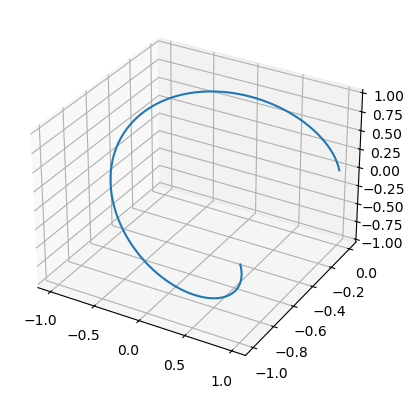

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

curve = generate_helix(2000, 1, -1,1,False)
print("Distance between points :", np.linalg.norm(curve[-1]-curve[0]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*curve.T)
plt.show()

Distance between points : 10.0


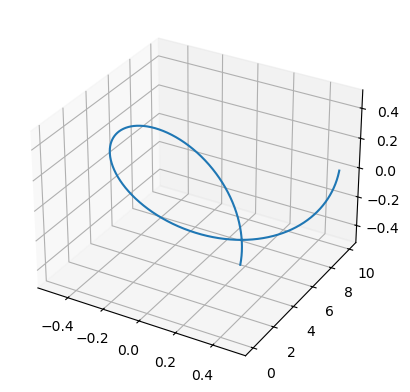

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

curve = generate_helix(2000, 1/2, 10,1,False)
print("Distance between points :", np.linalg.norm(curve[-1]-curve[0]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*curve.T)
plt.show()

In [21]:
import numpy as np
import plotly.graph_objects as go


fig = go.Figure()

path = generate_helix(2000, 1/2 ,2, 1,True)
print(path.shape)
x = path[:,0]
y = path[:,1]
z = path[:,2]
# Création d’un plot 3D interactif
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines',
    line=dict(color='blue', width=4)
))


path = generate_helix(2000, 1/4, 2,1,False)
print(path.shape)
x = path[:,0]
y = path[:,1]
z = path[:,2]
# Création d’un plot 3D interactif
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines',
    line=dict(color='red', width=4)
))
path = generate_helix(2000, 1/8, 2,1,False)
print(path.shape)
x = path[:,0]
y = path[:,1]
z = path[:,2]
# Création d’un plot 3D interactif
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines',
    line=dict(color='green', width=4)
))
# Mise en forme
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ),
    title="Hélicoïdale 3D interactive"
)

# Enregistrer dans un fichier HTML
fig.write_html("helix_plot.html")


(2000, 3)
(2000, 3)
(2000, 3)
